
# IMPORTING NECCESSARY LIBRARIES 

Importing preprocess ,it is a another file where i defined and execute all the main functions 

In [7]:
import preprocess
import classify
import numpy as np
from PIL import Image
import cv2



# DEFINING THE IMAGE PATH

In [8]:
# Define the image file name
image_path = "input.jpeg" 


 # PREPROCESSING THE IMAGE 

In [9]:
def preprocess_img(image_path):
    img = cv2.imread(image_path)  # Read image using OpenCV
    result_img, transitional_imgs, components, rects = preprocess.driver_preprocess(img)
    return result_img, transitional_imgs, components, rects


# CLASSIFYING THE COMPONENT

In [10]:
def classify_components(list_comp, image_path, rects):
    """Loads an image and classifies detected components."""
    img = np.array(Image.open(image_path))  # Open image using PIL
    classified, annotated_img = classify.driver_classify(list_comp, img, rects)
    return classified, annotated_img

# MAIN FILE 

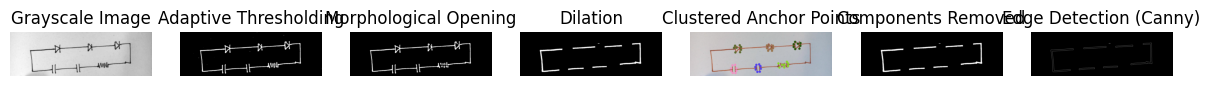

ValueError: too many values to unpack (expected 4)

In [11]:
def main():
    # Step 1: Preprocess the image
    result_img, transitional_imgs, components, rects = preprocess_img(image_path)

    # Step 2: Classify the detected components
    #classified, annotated_img = classify_components(components, IMAGE_PATH, rects)

    # Step 3: Save and show results
    cv2.imwrite("processed_circuit.jpg", result_img)
   # cv2.imwrite("annotated_circuit.jpg", annotated_img)
    print("Processing complete! Images saved.")

if __name__ == '__main__':
    main()

NOW the image which is preprocessed gets saved 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

transition_list = []

def show_images(images, titles):
    """Display images in a vertical sequence (one below the other)."""
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 1, figsize=(6, 4 * num_images))  # Adjust height dynamically
    
    if num_images == 1:
        axes = [axes]  # Ensure iterable axes for a single image

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()  # Adjust spacing to prevent overlap
    plt.show()

def initial_filtering(img):
    """Convert to grayscale, apply adaptive thresholding, and remove noise."""
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    transition_list.append(("Grayscale Image", img))

    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 31, 21)
    transition_list.append(("Adaptive Thresholding", img))

    k3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, k3, iterations=2)
    transition_list.append(("Morphological Opening", img))

    k3_2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    img = cv2.dilate(img, k3_2, iterations=2)
    transition_list.append(("Dilation", img))

    return img

def cluster_anchor_points(img, original_img):
    """Detect anchor points and cluster them."""
    anchor_points = cv2.goodFeaturesToTrack(image=img, maxCorners=100, qualityLevel=0.40, minDistance=20, blockSize=15)
    anchor_points = np.float32(anchor_points.reshape((-1, 2)))
    clustering = DBSCAN(eps=80, min_samples=4).fit(anchor_points)
    labels = clustering.labels_
    unique_labels, counts = np.unique(labels, return_counts=True)

    cluster_plot = original_img.copy()
    for l in unique_labels:
        if l == -1: continue
        px = [int(i[0]) for i in anchor_points[labels == l]]
        py = [int(i[1]) for i in anchor_points[labels == l]]
        color = np.random.randint(0, 255, (3,)).tolist()
        for i in range(len(px)):
            cv2.circle(cluster_plot, (px[i], py[i]), 5, color, thickness=10)

    transition_list.append(("Clustered Anchor Points", cluster_plot))

    return anchor_points, labels, unique_labels, counts

def remove_components(img, anchor_points, labels, unique_labels, counts):
    """Extract components from the image."""
    ext_img = img.copy()
    rects = []
    
    for l, _ in enumerate(counts):
        if l == 0: continue
        px = [int(i[0]) for i in anchor_points[labels == unique_labels[l]]]
        py = [int(i[1]) for i in anchor_points[labels == unique_labels[l]]]
        if abs(max(py)-min(py)) * abs(max(px)-min(px)) > 700:
            img[min(py)-15:max(py)+15, min(px)-15:max(px)+15] = 0
            rects.append([min(px)-22,max(px)+22,min(py)-22,max(py)+22])

    transition_list.append(("Components Removed", img))
    return img, rects

def wire_mapping(img):
    """Map the wiring paths."""
    edges = cv2.Canny(img, 50, 150)
    transition_list.append(("Edge Detection (Canny)", edges))
    return edges

def driver_preprocess(img):
    """Run the full preprocessing pipeline and display results in Jupyter Notebook."""
    transition_list.clear()
    original_img = img.copy()

    img = initial_filtering(img)
    anchor_points, labels, unique_labels, counts = cluster_anchor_points(img.copy(), original_img)
    img, rects = remove_components(img, anchor_points, labels, unique_labels, counts)
    img = wire_mapping(img)

    # Ensure exactly 4 values are returned
    return img, transition_list, anchor_points, rects

def preprocess_img(image_path):
    """Loads an image, preprocesses it, and returns results."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Error: Image could not be loaded. Check the file path.")

    result_img, transitional_imgs, components, rects = driver_preprocess(img)

    # Display all transition images in Jupyter Notebook in a vertical sequence
    show_images([t[1] for t in transitional_imgs], [t[0] for t in transitional_imgs])

    return result_img, transitional_imgs, components, rects

def main():
    image_path = "input.jpeg"  # Replace with your actual image file

    # Step 1: Preprocess the image
    result_img, transitional_imgs, components, rects = preprocess_img(image_path)

    # Step 2: Save the processed image
    cv2.imwrite("processed_circuit.jpg", result_img)

    print("Processing complete! Images saved.")

if __name__ == '__main__':
    main()
